# Stacking Models
- Scalecast allows you to stack models of different classes together.  
- You can add the predictions of any given model to the `Forecaster` object as a covariate, which scalecast refers to as "signals". This is through the use of the `Forecaster.add_signals()` method. See the [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.add_signals).  
- These signals can come from any model class available in scalecast and are treated the same as any other covariate. They can be combined with other covariates (such as series lags, seasonal representations, and trends). They can also be added to an `MVForecaster` object for multivariate forecasting. The signals from Meta Prophet or LinkedIn Silverkite, which add holiday effects to models, can be added to the objects to capture the uniqueness of these models' specifications.  
- We will use symmetric mean percentage error ([SMAPE](https://scalecast.readthedocs.io/en/latest/Forecaster/Util.html#src.scalecast.util.metrics.smape)) to measure the performance of each model in this notebook.  
- Requirements:
  - `scalecast>=0.17.9`
  - `tensorflow`
  - `shap`
- Data source: [M4](https://github.com/Mcompetitions/M4-methods/tree/master/Dataset)

In [1]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from scalecast.util import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def read_data(idx = 'H1', cis = True, metrics = ['smape']):
    info = pd.read_csv(
        'M4-info.csv',
        index_col=0,
        parse_dates=['StartingDate'],
        dayfirst=True,
    )
    train = pd.read_csv(
        f'Hourly-train.csv',
        index_col=0,
    ).loc[idx]
    test = pd.read_csv(
        f'Hourly-test.csv',
        index_col=0,
    ).loc[idx]
    y = train.values
    sd = info.loc[idx,'StartingDate']
    fcst_horizon = info.loc[idx,'Horizon']
    cd = pd.date_range(
        start = sd,
        freq = 'H',
        periods = len(y),
    )
    f = Forecaster(
        y = y,
        current_dates = cd,
        future_dates = fcst_horizon,
        test_length = fcst_horizon,
        cis = cis,
        metrics = metrics,
    )
    
    return f, test.values

In [3]:
f, test_set = read_data()
f

Forecaster(
    DateStartActuals=2015-07-12T08:00:00.000000000
    DateEndActuals=2015-08-10T11:00:00.000000000
    Freq=H
    N_actuals=700
    ForecastLength=48
    Xvars=[]
    Differenced=0
    TestLength=48
    ValidationLength=1
    ValidationMetric=smape
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

We are using the H1 series from the M4 competition, but you can change the value passed to the `idx` argument in the function above to test this same analysis with any hourly series in the dataset.

## EDA

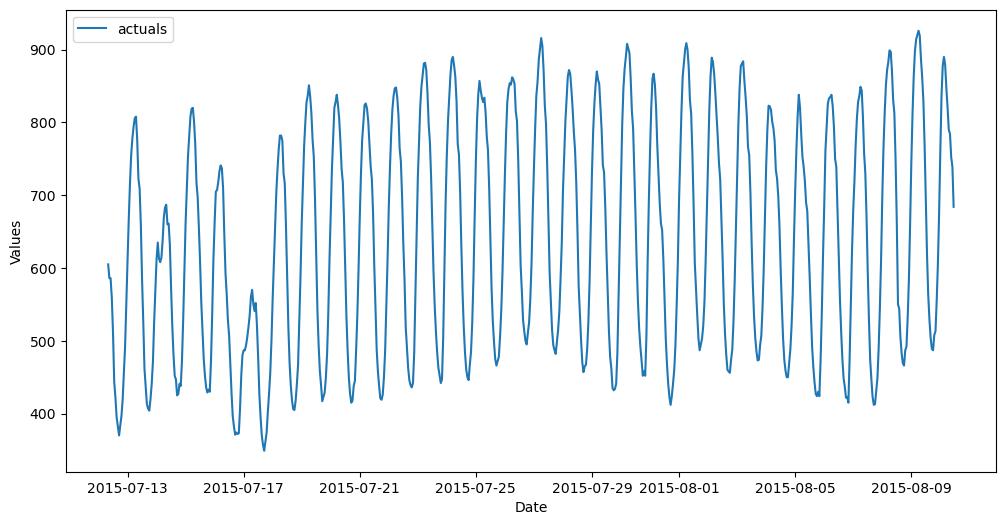

In [4]:
f.plot()
plt.show()

### ACF/PACF at Series Level

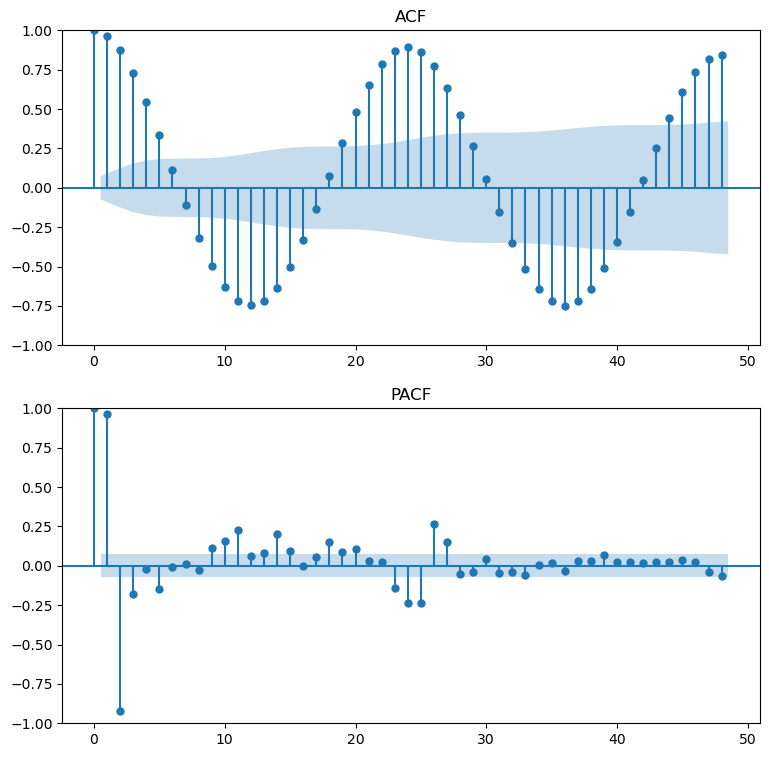

In [5]:
figs, axs = plt.subplots(2, 1,figsize=(9,9))
f.plot_acf(ax=axs[0],title='ACF',lags=48)
f.plot_pacf(ax=axs[1],title='PACF',lags=48,method='ywm')
plt.show()

### Augmented Dickey-Fuller Test

In [6]:
critical_pval = 0.05
print('Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

Augmented Dickey-Fuller results:
the test-stat value is: -2.06
the p-value is 0.2623
the series is not stationary
----------------------------------------------------------------------------------------------------


### ACF/PACF at Series First Difference

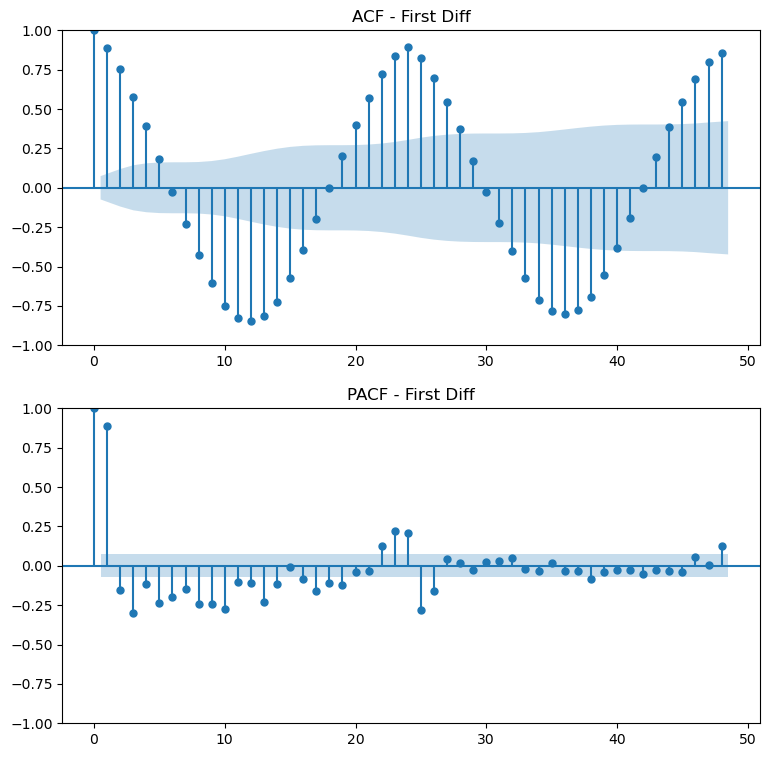

In [37]:
figs, axs = plt.subplots(2, 1,figsize=(9,9))
f.plot_acf(ax=axs[0],title='ACF - First Diff',lags=48,diffy=1)
f.plot_pacf(ax=axs[1],title='PACF - First Diff',lags=48,diffy=1,method='ywm')
plt.show()

### Seasonal Decomp

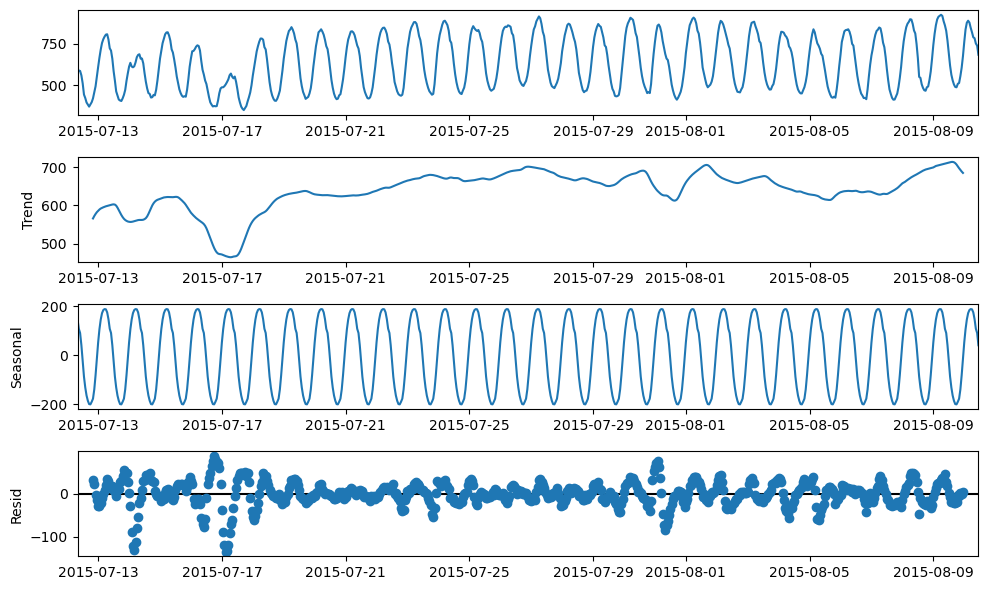

In [8]:
plt.rc("figure",figsize=(10,6))
f.seasonal_decompose().plot()
plt.show()

## Naive
- This will serve as a benchmark model
- It will propagate the last 24 observations in a "seasonal naive" model

In [9]:
f.set_estimator('naive')
f.manual_forecast(seasonal=True)

## ARIMA

### Manual ARIMA: (5,1,4) x (1,1,1,24)

In [10]:
f.set_estimator('arima')
f.manual_forecast(
    order = (5,1,4),
    seasonal_order = (1,1,1,24),
    call_me = 'manual_arima',
)

## RNN

### Tanh Activation

2023-02-26 11:34:08.294818: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-26 11:34:09.851817: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/15
14/14 [==============================] - 4s 118ms/step - loss: 0.3531 - val_loss: 0.2693
Epoch 2/15
14/14 [==============================] - 1s 63ms/step - loss: 0.2494 - val_loss: 0.2602
Epoch 3/15
14/14 [==============================] - 1s 63ms/step - loss: 0.2281 - val_loss: 0.2213
Epoch 4/15
14/14 [==============================] - 1s 63ms/step - loss: 0.1246 - val_loss: 0.1886
Epoch 5/15
14/14 [==============================] - 1s 63ms/step - loss: 0.0717 - val_loss: 0.1848
Epoch 6/15
14/14 [==============================] - 1s 63ms/step - loss: 0.0608 - val_loss: 0.1725
Epoch 7/15
14/14 [==============================] - 1s 63ms/step - loss: 0.0596 - val_loss: 0.1557
Epoch 8/15
14/14 [==============================] - 1s 63ms/step - loss: 0.0584 - val_loss: 0.1675
Epoch 9/15
14/14 [==============================] - 1s 63ms/step - loss: 0.0556 - val_loss: 0.1648
Epoch 10/15
14/14 [==============================] - 1s 64ms/step - loss: 0.0522 - val_loss: 0.1584
Epoch 11

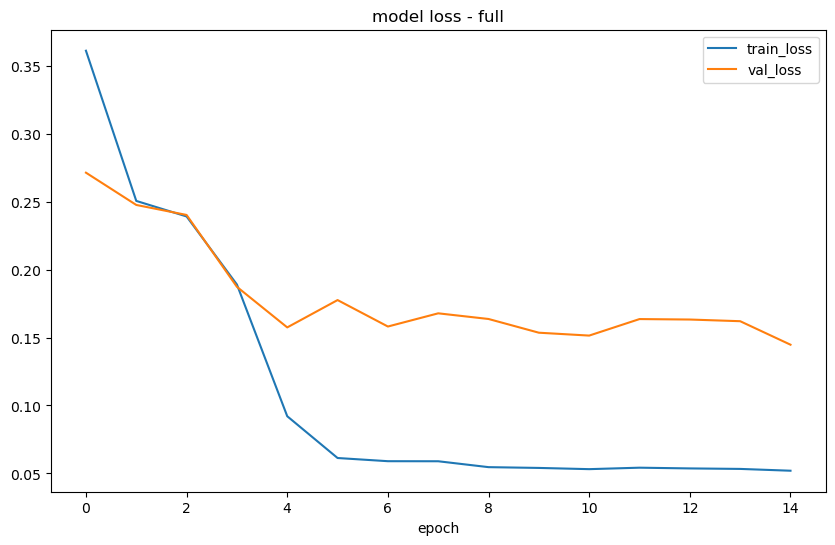

19/19 [==============================] - 0s 21ms/step


In [11]:
f.set_estimator('rnn')
f.manual_forecast(
    lags = 48,
    layers_struct=[
        ('LSTM',{'units':100,'activation':'tanh'}),
        ('LSTM',{'units':100,'activation':'tanh'}),
        ('LSTM',{'units':100,'activation':'tanh'}),
    ],
    optimizer = 'Adam',
    epochs = 15,
    plot_loss = True,
    validation_split=0.2,
    call_me = 'rnn_tanh_activation',
)

### Relu Activation

Epoch 1/15
14/14 [==============================] - 3s 80ms/step - loss: 0.5077 - val_loss: 0.2819
Epoch 2/15
14/14 [==============================] - 1s 61ms/step - loss: 0.3717 - val_loss: 0.2583
Epoch 3/15
14/14 [==============================] - 1s 60ms/step - loss: 0.2856 - val_loss: 0.2341
Epoch 4/15
14/14 [==============================] - 1s 61ms/step - loss: 0.2499 - val_loss: 0.2425
Epoch 5/15
14/14 [==============================] - 1s 61ms/step - loss: 0.2456 - val_loss: 0.2456
Epoch 6/15
14/14 [==============================] - 1s 61ms/step - loss: 0.2439 - val_loss: 0.2450
Epoch 7/15
14/14 [==============================] - 1s 61ms/step - loss: 0.2404 - val_loss: 0.2427
Epoch 8/15
14/14 [==============================] - 1s 61ms/step - loss: 0.2325 - val_loss: 0.2379
Epoch 9/15
14/14 [==============================] - 1s 61ms/step - loss: 0.2060 - val_loss: 0.2191
Epoch 10/15
14/14 [==============================] - 1s 61ms/step - loss: 0.1624 - val_loss: 0.1927
Epoch 11/

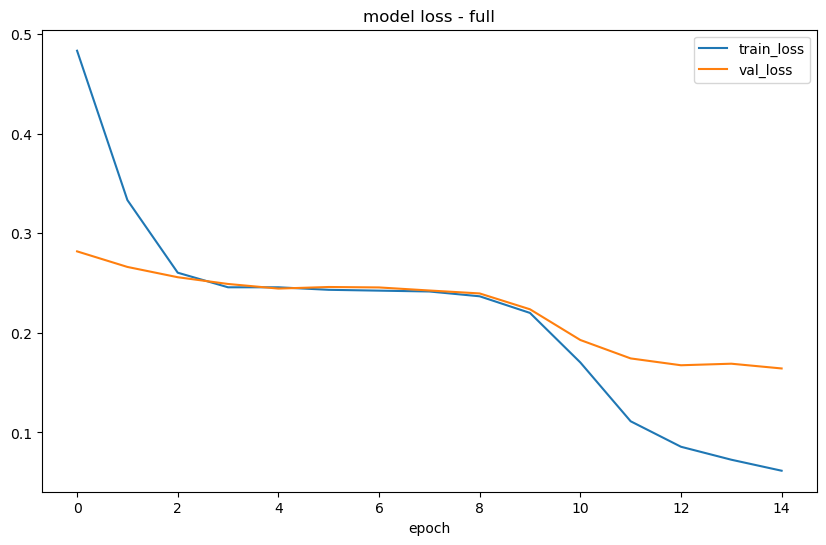

19/19 [==============================] - 0s 21ms/step


In [12]:
f.manual_forecast(
    lags = 48,
    layers_struct=[
        ('LSTM',{'units':100,'activation':'relu'}),
        ('LSTM',{'units':100,'activation':'relu'}),
        ('LSTM',{'units':100,'activation':'relu'}),
    ],
    optimizer = 'Adam',
    epochs = 15,
    plot_loss = True,
    validation_split=0.2,
    call_me = 'rnn_relu_activation',
)

## Prophet

In [13]:
f.set_estimator('prophet')
f.manual_forecast()

11:35:18 - cmdstanpy - INFO - Chain [1] start processing
11:35:18 - cmdstanpy - INFO - Chain [1] done processing
11:35:18 - cmdstanpy - INFO - Chain [1] start processing
11:35:18 - cmdstanpy - INFO - Chain [1] done processing


## Compare Results

In [14]:
results = f.export(determine_best_by='TestSetSMAPE')
ms = results['model_summaries']
ms[
    [
        'ModelNickname',
        'TestSetLength',
        'TestSetSMAPE',
        'InSampleSMAPE',
    ]
]

,ModelNickname,TestSetLength,TestSetSMAPE,InSampleSMAPE
0,manual_arima,48,0.046551,0.017995
1,prophet,48,0.047237,0.043859
2,rnn_tanh_activation,48,0.054419,0.067321
3,rnn_relu_activation,48,0.060657,0.083589
4,naive,48,0.093079,0.067697


Using the last 48 observations in the `Forecaster` object to test each model, the arima model performed the best.

## Plot Results

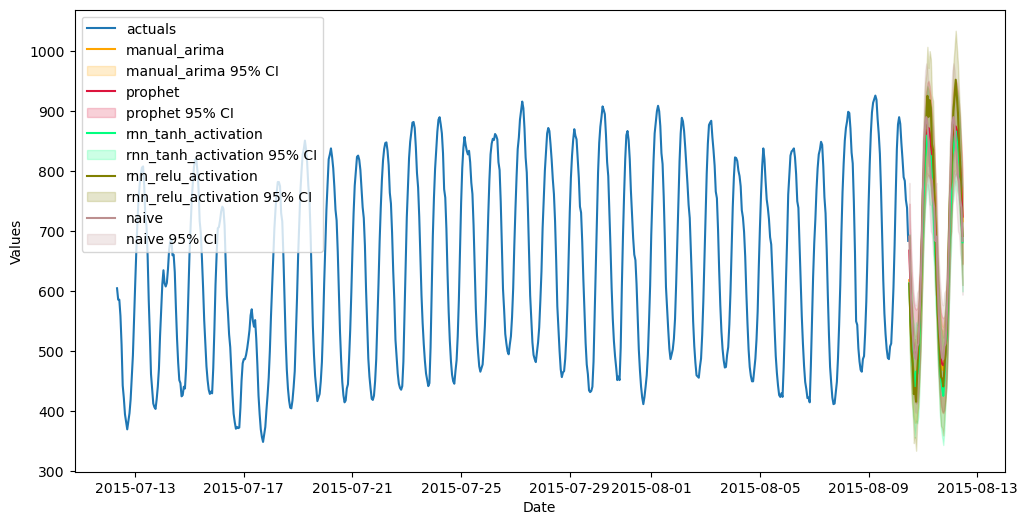

In [15]:
f.plot(order_by="TestSetSMAPE",ci=True)
plt.show()

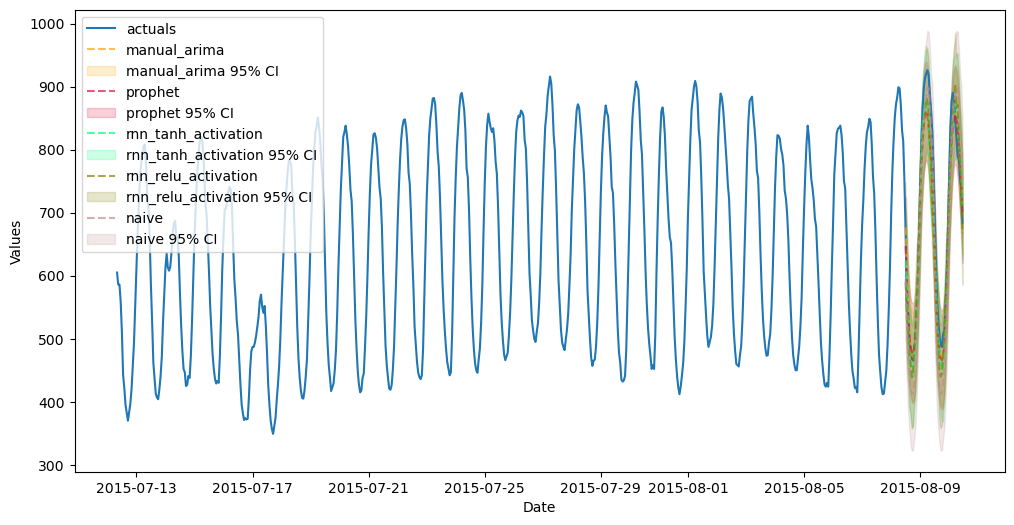

In [16]:
f.plot_test_set(order_by="TestSetSMAPE",ci=True)
plt.show()

## Stack Models

- To stack models in scalecast, you can either use the [StackingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html) from scikit-learn, or you can add the predictions from already-evaluated models into the `Forecaster` object using `Forecaster.add_signals()`. The latter approach is more advantageous as it can do everything that can be done with the StackingRegressor, but it can use non scikit-learn model classes, can combine with other regressors, and is easier to tune.  
- In the below example, we are using the signals generated from two LSTM models, an ARIMA model, a naive model, and Meta Prophet. We will also add the last 48 series lags to the object.  
- One key point in the function below: we are specifying the `train_only` argument as False. This means that our test set will be compromised as we will introduce leakage from the other models. I chose to leave it False because this approach will ultimately be tested with a separate out-of-sample test set. The rule of thumb around this is to make this argument True if you want to report accurate test-set metrics but leave False when you want to deliver a Forecast into a future horizon. You can run this function twice with each option specified if you want to do both--run first time with `train_only=True`, evaluate models, and check the test-set metrics. Then, rerun with `train_only=False` and re-evaluate models to deliver future point predictions.  

In [17]:
f.add_ar_terms(48)
f.add_signals(
    f.history.keys(),
    #train_only = True, # uncomment to avoid leakage into the test set
)
f.set_estimator('catboost')
f

Forecaster(
    DateStartActuals=2015-07-12T08:00:00.000000000
    DateEndActuals=2015-08-10T11:00:00.000000000
    Freq=H
    N_actuals=700
    ForecastLength=48
    Xvars=['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'AR29', 'AR30', 'AR31', 'AR32', 'AR33', 'AR34', 'AR35', 'AR36', 'AR37', 'AR38', 'AR39', 'AR40', 'AR41', 'AR42', 'AR43', 'AR44', 'AR45', 'AR46', 'AR47', 'AR48', 'signal_naive', 'signal_manual_arima', 'signal_rnn_tanh_activation', 'signal_rnn_relu_activation', 'signal_prophet']
    Differenced=0
    TestLength=48
    ValidationLength=1
    ValidationMetric=smape
    ForecastsEvaluated=['naive', 'manual_arima', 'rnn_tanh_activation', 'rnn_relu_activation', 'prophet']
    CILevel=0.95
    CurrentEstimator=catboost
    GridsFile=Grids
)

Now we can train three catboost models:
- One with all added regressors (the model signals and lags)  
- One with just the model signals  
- One with just the series lags  

In [31]:
f.manual_forecast(
    Xvars='all',
    call_me='catboost_all_reg',
    verbose = False,
)
f.save_feature_importance(method = 'shap') # it would be interesting to see the shapley scores (later)
f.manual_forecast(
    Xvars=[x for x in f.get_regressor_names() if x.startswith('AR')], 
    call_me = 'catboost_lags_only',
    verbose = False,
)
f.manual_forecast(
    Xvars=[x for x in f.get_regressor_names() if not x.startswith('AR')], 
    call_me = 'catboost_signals_only',
    verbose = False,
)

In [32]:
results = f.export(determine_best_by='TestSetSMAPE')
ms = results['model_summaries']
ms[
    [
        'ModelNickname',
        'TestSetLength',
        'TestSetSMAPE',
        'InSampleSMAPE',
    ]
]

,ModelNickname,TestSetLength,TestSetSMAPE,InSampleSMAPE
0,catboost_signals_only,48,0.015921,0.005787
1,catboost_all_reg,48,0.021880,0.003378
2,manual_arima,48,0.046551,0.017995
3,prophet,48,0.047237,0.043859
4,rnn_tanh_activation,48,0.054419,0.067321
5,catboost_lags_only,48,0.060460,0.003447
6,rnn_relu_activation,48,0.060657,0.083589
7,naive,48,0.093079,0.067697


Unsuprisingly, now our catboost model with just the signals is showing the best test-set scores. But the test set has been compromised for all models that used signals as inputs. To really know how these models performed out-of-sample, we need to compare it with a separate out-of-sample test set.

## Check Performance of Forecast on Held-Out Sample

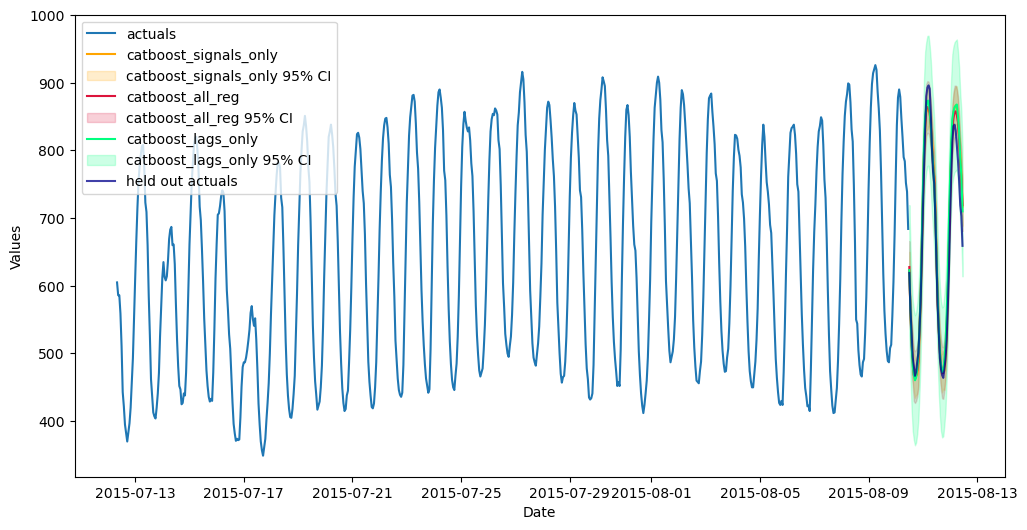

In [33]:
fig, ax = plt.subplots(figsize=(12,6))
f.plot(
    models = [m for m in f.history if m.startswith('catboost')],
    order_by="TestSetSMAPE",
    ci=True,
    ax = ax
)
sns.lineplot(
    x = f.future_dates, 
    y = test_set, 
    ax = ax,
    label = 'held out actuals',
    color = 'darkblue',
    alpha = .75,
)
plt.show()

In [34]:
test_results = pd.DataFrame(index = f.history.keys(),columns = ['smape','mase'])
for k, v in f.history.items():
    test_results.loc[k,['smape','mase']] = [
        metrics.smape(test_set,v['Forecast']),
        metrics.mase(test_set,v['Forecast'],m=24,obs=f.y),
    ]
    
test_results.sort_values('smape')

,smape,mase
catboost_all_reg,0.02873,0.475995
catboost_signals_only,0.02885,0.488486
manual_arima,0.032933,0.542456
rnn_tanh_activation,0.035042,0.541273
catboost_lags_only,0.035476,0.585321
prophet,0.039312,0.632253
rnn_relu_activation,0.052336,0.867283
naive,0.052629,0.827014


Now, we finally get to the crux of the analysis, where we can see that the catboost that used both the other model signals and the series lags performed best, followed by the catboost model that used only signals. This demonstrates the power of stacking and how it can make good models great.

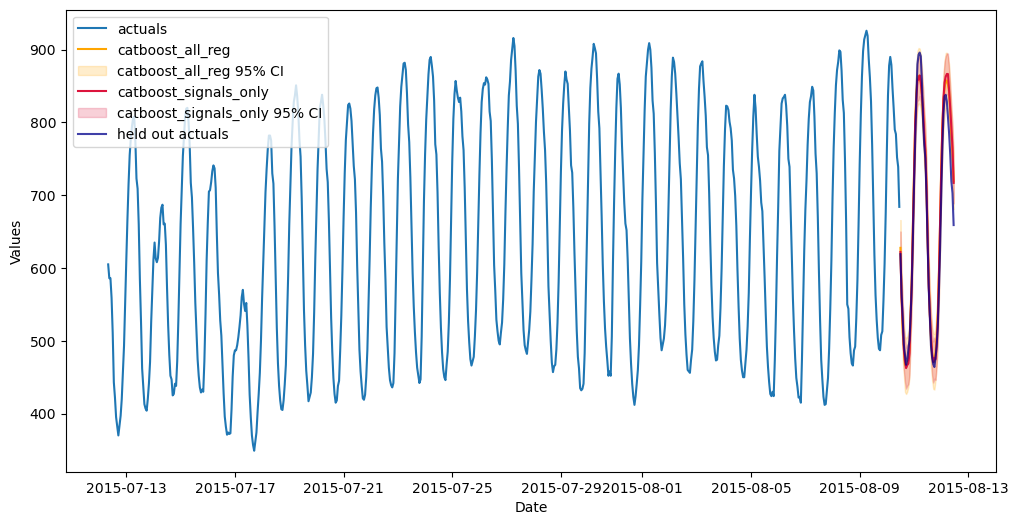

In [35]:
fig, ax = plt.subplots(figsize=(12,6))
f.plot(
    models = ['catboost_all_reg','catboost_signals_only'],
    ci=True,
    ax = ax
)
sns.lineplot(
    x = f.future_dates, 
    y = test_set, 
    ax = ax,
    label = 'held out actuals',
    color = 'darkblue',
    alpha = .75,
)
plt.show()

## View each covariate's shapley score
- Looking at the scores below, it is not surprising that the ARIMA signal was deemed the most important covariate in the final catboost model. The next most important was the series' first lag and then the prophet model. If we had only used the StackingRegressor from scikit-learn, we wouldn't have been able to use such a diverse model stack and combine it with the series' lags.

In [39]:
f.export_feature_importance('catboost_all_reg')

,weight,std
feature,,
signal_manual_arima,44.262455,20.679786
AR1,22.029738,11.459854
signal_prophet,16.914519,7.706479
AR48,4.895960,1.964597
AR3,4.347847,3.413859
AR24,4.254107,2.481860
signal_rnn_relu_activation,3.780970,1.243303
signal_rnn_tanh_activation,3.772280,1.524622
AR46,3.585660,1.522349
